# Mushroom Classifier

## Dataset description:
- There are 9 folders of images of most common Northern European mushrooms genuses inside of this dataset. Each folder consist of from 300 to 1500 selected images of mushrooms genuses. Labels are the folder's names.
- Link to dataset: https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images

## Mushroom classes description:
- ``Agaricus`` (generally edible) - A genus of mushrooms containing both edible and poisonous species. Some edible species include the common mushroom Agaricus bisporus. Not all poisonous.

- ``Amanita`` (mostly poisonous) - A genus containing many toxic and deadly poisonous species like the death cap, as well as some edible species. Many poisonous species.

- ``Boletus`` (edible) - A genus known for edible porcini mushrooms. Rich in umami flavor. None are poisonous.

- ``Cortinarius`` (mostly poisonous) - A genus with many species, most of which are inedible or poisonous due to toxicity. Contains some deadly poisonous species. Many poisonous.

- ``Entoloma`` (edible/poisonous) - A large genus with some edible species but also some poisonous species that contain toxins causing gastrointestinal issues. Some poisonous.

- ``Hygrocybe`` (edible) - A genus of edible and inedible mushrooms, but containing no poisonous species. None poisonous.

- ``Lactarius`` (generally edible) - Many Lactarius species are edible, and some are highly prized for their culinary qualities. However, some can cause stomach upset, so proper identification is important.

- ``Russula`` (edible/poisonous) - Russula mushrooms include both edible and inedible species. While some are edible and tasty, others may be inedible or cause mild toxicity.

- ``Suillus`` (edible) - A genus of edible mushrooms, important commercially and for food. No deadly poisonous species known in this genus. None poisonous.


## Motivation:
In US alone, around 7500 yearly cases of mushrooms poisoning are reported. According to statistics, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education". To avoid expenses for hospitalization and in some cases pointless deaths, we want to create a machine learning model, that can recognize mushroom types. We want to help people make the right choice when mushroom picking.

## Main objectives:
- Perform EDA and data preprocessing.
- Create Pytorch Lightning training, validation, and testing dataloaders.
- Create transfer learning model and fine-tune it.
- Plot the training and validation metrics throughout training epochs.
- Test the best-performing model on test data.

## Biases:
- Some of the mushroom classes contain both poisonous and edible subclasses. We would benefit from getting more granular labels.

# 1. Loading libraries and preprocessing data

In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 12.3 MB/s eta 0:00:00


In [2]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import sample
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from PIL import Image
import glob
from torch.utils.data import SubsetRandomSampler

import pytorch_lightning as pl
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import random_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms'

In [5]:
class_names = ['Agaricus',
               'Cortinarius',
               'Russula',
               'Suillus',
               'Entoloma',
               'Hygrocybe',
               'Amanita',
               'Boletus',
               'Lactarius']
num_classes = len(class_names)

# 2. EDA

Visualizing example images for each class

Random images of each mushroom class before any transformations:
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Agaricus/413_4LTr0R0Dk8o.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Amanita/633_h1geqGA79wI.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Boletus/0635_-J_6XTsYZMA.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Cortinarius/608_p6zV2P9IBKs.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Entoloma/046_enK4P7PWtkY.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms/Hygrocybe/217_OyhcdufzSCo.jpg
Plotted image: /content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_

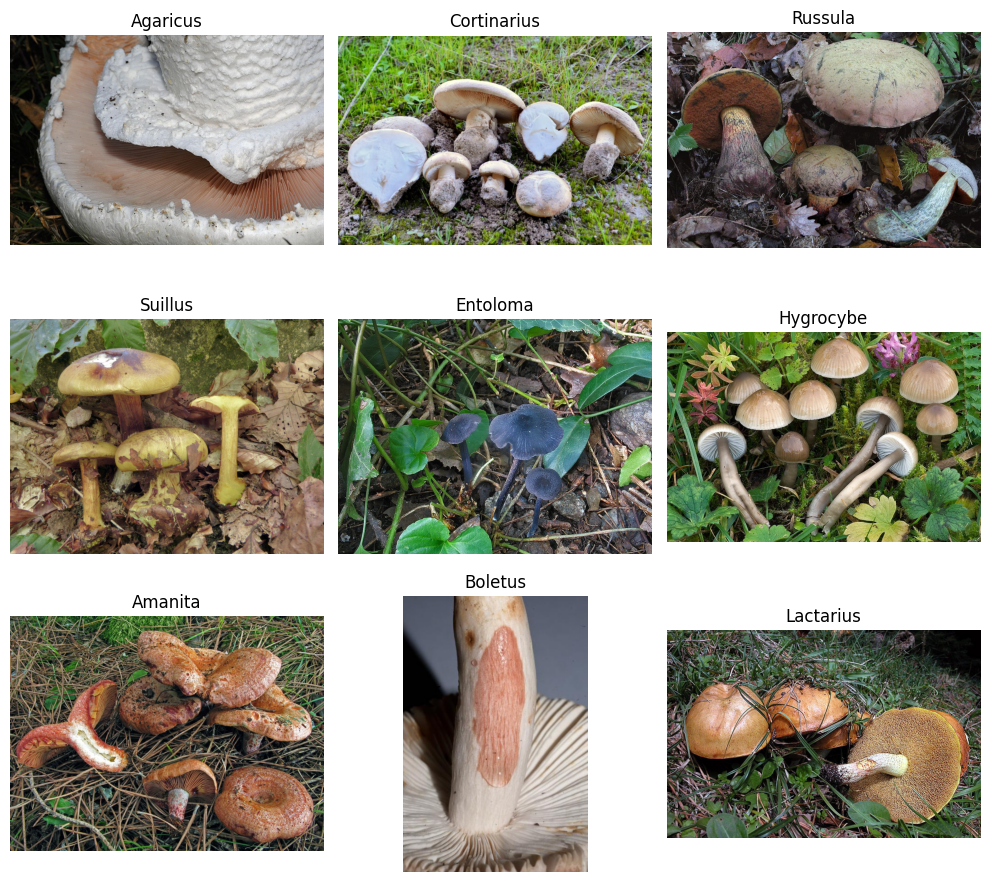

In [6]:
print("Random images of each mushroom class before any transformations:")

orig_data = datasets.ImageFolder(data_dir)

sample_inputs = []
for i in range(num_classes):
    class_samples = [s for s in orig_data.samples if s[1] == i]
    sample_idx = random.randint(0, len(class_samples)-1)
    path, _ = class_samples[sample_idx]
    img = Image.open(path)
    sample_inputs.append(np.asarray(img))
    print(f"Plotted image: {path}")

num_rows = num_classes // 3
fig, axs = plt.subplots(num_rows, 3, figsize=(10, 3*num_rows))
for i in range(num_classes):
    row = i // 3
    col = i % 3
    axs[row, col].imshow(sample_inputs[i])
    axs[row, col].set_title(class_names[i])
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Visualizing class distributions

Class: Agaricus, Count: 353
Class: Cortinarius, Count: 836
Class: Russula, Count: 1147
Class: Suillus, Count: 311
Class: Entoloma, Count: 364
Class: Hygrocybe, Count: 316
Class: Amanita, Count: 750
Class: Boletus, Count: 1073
Class: Lactarius, Count: 1563


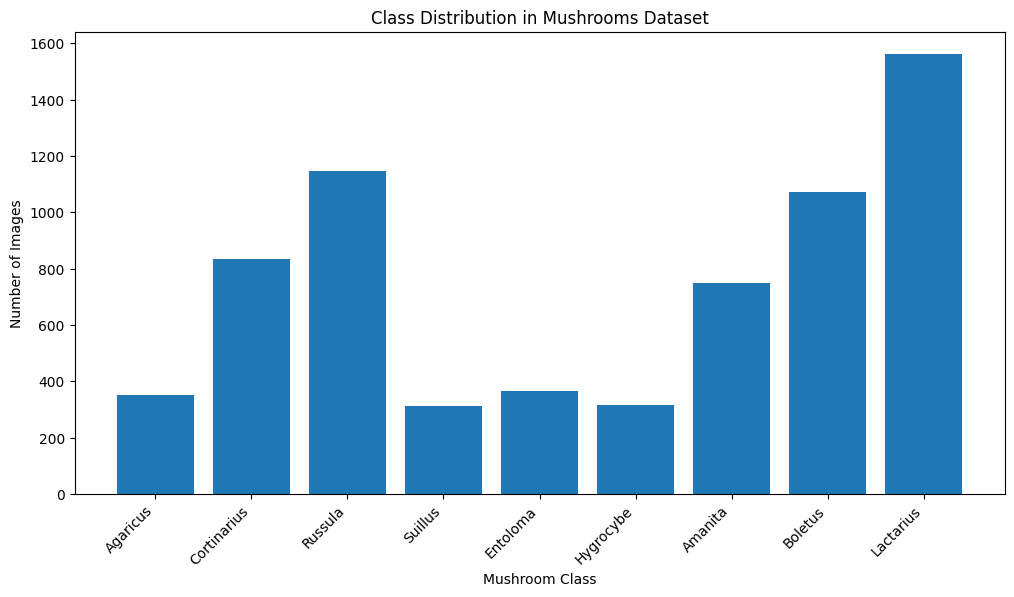

In [7]:
data_dir = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms'

class_counts = {class_name: 0 for class_name in class_names}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(class_counts.keys(), class_counts.values())
ax.set_xlabel('Mushroom Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution in Mushrooms Dataset')
plt.xticks(rotation=45, ha='right')
plt.show()

# Model Training

In [8]:
from torchvision.models import ResNet18_Weights
from torchsummary import summary
from torchvision import transforms, models

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
summary(model, (3, 224, 224), device="cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
def load_image(img_path):
    base_name = os.path.basename(img_path)
    if base_name.startswith('.DS') or os.path.isdir(img_path):
        return None, None
    img = Image.open(img_path)
    img = img.convert('RGB')

    return img

def get_class_from_path(img_path):
    base_name = os.path.basename(img_path)
    class_name = base_name.split(os.path.sep)[-2]
    class_id = class_names.index(class_name)
    return class_id

def get_class_names(data_dir):
    class_names = []
    for folder in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, folder)):
            class_names.append(folder)
    return class_names

Uncomment the code below if you're working with newly downloaded dataset to remove corrupted images:

In [10]:
# data_dir = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/Mushrooms'

# corrupted_images = []

# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         file_path = os.path.join(root, file)
#         try:
#             img = Image.open(file_path).convert('RGB')
#         except OSError:
#             print(f"Corrupted image found: {file_path}")
#             corrupted_images.append(file_path)

# for img_path in corrupted_images:
#     os.remove(img_path)

# print(f"Removed {len(corrupted_images)} corrupted images")

## Building the data module

In [11]:
%%time
class MushroomDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str, batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.class_names = get_class_names(self.data_dir)
        self.num_classes = len(self.class_names)

    def prepare_data(self):

        self.train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(),
            transforms.RandomResizedCrop((224, 224)),
        ])

        self.val_test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


    def setup(self):

        full_dataset = datasets.ImageFolder(self.data_dir)
        print("len of Full Dataset: ", len(full_dataset))

        self.train_size = int(0.8 * len(full_dataset))
        self.val_size = int(0.1 * len(full_dataset))
        self.test_size = len(full_dataset) - self.train_size - self.val_size

        self.train_data, self.val_data, self.test_data = random_split(full_dataset,
                                                                      [self.train_size,
                                                                       self.val_size,
                                                                       self.test_size])
        print("len of Train Dataset: ", len(self.train_data))
        print("len of Validation Dataset: ", len(self.val_data))
        print("len of Test Dataset: ", len(self.test_data))

        self.train_data.dataset.transform = self.train_transforms
        self.val_data.dataset.transform = self.val_test_transforms
        self.test_data.dataset.transform = self.val_test_transforms

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True,
                          num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=2)

dm = MushroomDataModule(data_dir=data_dir)
dm.prepare_data()
dm.setup()

len of Full Dataset:  6713
len of Train Dataset:  5370
len of Validation Dataset:  671
len of Test Dataset:  672
CPU times: user 26.6 ms, sys: 3.04 ms, total: 29.6 ms
Wall time: 102 ms


In [12]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

## Pre-trained CNN as a Feature Extractor with Image Augmentation

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy, Precision, Recall
from pytorch_lightning.loggers import TensorBoardLogger

In [14]:
def print_metrics(model):
  print(f'Final Training Loss: {model.train_losses[-1]:.4f}')
  print(f'Final Validation Loss: {model.val_losses[-1]:.4f}')
  print("-"*20)

  print(f'Final Training Accuracy: {model.train_acc.compute():.4f}')
  print(f'Final Validation Accuracy: {model.val_acc.compute():.4f}')
  print("-"*20)

  print(f'Final Training Recall: {model.train_recall.compute():.4f}')
  print(f'Final Validation Recall: {model.val_recall.compute():.4f}')
  print("-"*20)

  print(f'Final Training Precision: {model.train_precision.compute():.4f}')
  print(f'Final Validation Precision: {model.val_precision.compute():.4f}')
  print("-"*20)

In [15]:
class MushroomModel(pl.LightningModule):
    def __init__(self, num_classes,
              learning_rate=1e-3,
              transfer=False,
              unfreeze_layers=None,
              feature_extractor=models.resnet18(weights=ResNet18_Weights.DEFAULT),
              criterion=torch.nn.CrossEntropyLoss()):
        super().__init__()

        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.feature_extractor = feature_extractor

        if transfer:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

            if unfreeze_layers is not None:
                  for name, child in self.feature_extractor.named_children():
                      if name in unfreeze_layers:
                          for params in child.parameters():
                              params.requires_grad = True

        in_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = torch.nn.Linear(in_features, self.num_classes)

        self.criterion = criterion

        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_recall = Recall(average='macro', num_classes=num_classes,
                                   task='multiclass')
        self.val_recall = Recall(average='macro', num_classes=num_classes,
                                 task='multiclass')

        self.train_precision = Precision(average='macro', num_classes=num_classes,
                                         task='multiclass')
        self.val_precision = Precision(average='macro', num_classes=num_classes,
                                       task='multiclass')

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_recalls = []
        self.val_recalls = []
        self.train_precisions = []
        self.val_precisions = []


    def forward(self, x):
        return self.feature_extractor(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        train_acc = self.train_acc(y_hat, y)
        train_recall = self.train_recall(y_hat, y)
        train_precision = self.train_precision(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_accuracy', train_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_recall', train_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_precision', train_precision, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def validation_step(self, batch, batch_idx):
      with torch.no_grad():
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        val_acc = self.val_acc(logits, y)
        val_recall = self.val_recall(logits, y)
        val_precision = self.val_precision(logits, y)

        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_accuracy', val_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_recall', val_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_precision', val_precision, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def on_train_epoch_end(self):
        avg_train_loss = self.trainer.callback_metrics['train_loss'].mean()
        print(f"avg_train_loss: {avg_train_loss}")
        self.train_losses.append(avg_train_loss.item())

        avg_train_acc = self.trainer.callback_metrics['train_accuracy'].mean()
        train_acc = self.train_acc.compute()
        self.train_accuracies.append(avg_train_acc.item())

        avg_train_recall = self.trainer.callback_metrics['train_recall'].mean()
        train_recall = self.train_recall.compute()
        self.train_recalls.append(avg_train_recall.item())

        avg_train_precision = self.trainer.callback_metrics['train_precision'].mean()
        self.train_precisions.append(avg_train_precision.item())


    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val_loss'].mean()
        print(f"avg_val_loss: {avg_val_loss}")
        self.val_losses.append(avg_val_loss.item())

        avg_val_acc = self.trainer.callback_metrics['val_accuracy'].mean()
        print("avg_val_acc:", avg_val_acc.item())
        self.val_accuracies.append(avg_val_acc.item())

        avg_val_recall = self.trainer.callback_metrics['val_recall'].mean()
        print("avg_val_recall:", avg_val_recall.item())
        self.val_recalls.append(avg_val_recall.item())

        avg_val_precision = self.trainer.callback_metrics['val_precision'].mean()
        print("avg_val_precision:", avg_val_precision.item())
        self.val_precisions.append(avg_val_precision.item())

        print("-"*30)


    def plot_metrics(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 4, 2)
        plt.plot(self.train_accuracies, label="Train Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1, 4, 3)
        plt.plot(self.train_recalls, label="Train Recall")
        plt.plot(self.val_recalls, label="Validation Recall")
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.title('Recall')
        plt.legend()

        plt.subplot(1, 4, 4)
        plt.plot(self.train_precisions, label="Train Precision")
        plt.plot(self.val_precisions, label="Validation Precision")
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.title('Precision')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [16]:
%%time
basic_model = MushroomModel(num_classes=dm.num_classes, transfer=True)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(basic_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | criterion         | CrossEntropyLoss    | 0     
2 | train_acc         | MulticlassAccuracy  | 0     
3 | val_acc           | MulticlassAccuracy  | 0     
4 | train_recall      | MulticlassRecall    | 0     
5 | val_recall        | MulticlassRecall    | 0     
6 | train_precision   | MulticlassPrecision | 0     
7 | val_precision     | MulticlassPrecision | 0     
---------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.4183831214904785
avg_val_acc: 0.15625
avg_val_recall: 0.1416170597076416
avg_val_precision: 0.09252335131168365
------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.2397693395614624
avg_val_acc: 0.5514158010482788
avg_val_recall: 0.4827613830566406
avg_val_precision: 0.517198383808136
------------------------------
avg_train_loss: 1.5502736568450928


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.10402250289917
avg_val_acc: 0.6199702024459839
avg_val_recall: 0.5542688965797424
avg_val_precision: 0.5401922464370728
------------------------------
avg_train_loss: 1.1147444248199463


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0468958616256714
avg_val_acc: 0.63338303565979
avg_val_recall: 0.5543144941329956
avg_val_precision: 0.586717426776886
------------------------------
avg_train_loss: 1.0010766983032227


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9774537682533264
avg_val_acc: 0.6393442749977112
avg_val_recall: 0.574545681476593
avg_val_precision: 0.5894653797149658
------------------------------
avg_train_loss: 0.9196791648864746


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9715480804443359
avg_val_acc: 0.6497764587402344
avg_val_recall: 0.5719953775405884
avg_val_precision: 0.6045218706130981
------------------------------
avg_train_loss: 0.9014285802841187


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9509549140930176
avg_val_acc: 0.6572279930114746
avg_val_recall: 0.5890937447547913
avg_val_precision: 0.6135438084602356
------------------------------
avg_train_loss: 0.8442661762237549


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9549092054367065
avg_val_acc: 0.6557376980781555
avg_val_recall: 0.5891090035438538
avg_val_precision: 0.6179406046867371
------------------------------
avg_train_loss: 0.8344987630844116


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9405000805854797
avg_val_acc: 0.6751117706298828
avg_val_recall: 0.6034471988677979
avg_val_precision: 0.627515435218811
------------------------------
avg_train_loss: 0.8166418671607971


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9427294731140137
avg_val_acc: 0.6691505312919617
avg_val_recall: 0.622133731842041
avg_val_precision: 0.6436641812324524
------------------------------
avg_train_loss: 0.7817214727401733


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


avg_val_loss: 0.9550758600234985
avg_val_acc: 0.6676602363586426
avg_val_recall: 0.5937961339950562
avg_val_precision: 0.6269106268882751
------------------------------
avg_train_loss: 0.7851876020431519
CPU times: user 1min 28s, sys: 19.3 s, total: 1min 47s
Wall time: 22min 20s


In [17]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/basic_model_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [18]:
print_metrics(basic_model)

Final Training Loss: 0.7852
Final Validation Loss: 0.9551
--------------------
Final Training Accuracy: 0.6716
Final Validation Accuracy: 0.6373
--------------------
Final Training Recall: 0.6196
Final Validation Recall: 0.5863
--------------------
Final Training Precision: 0.6827
Final Validation Precision: 0.6293
--------------------


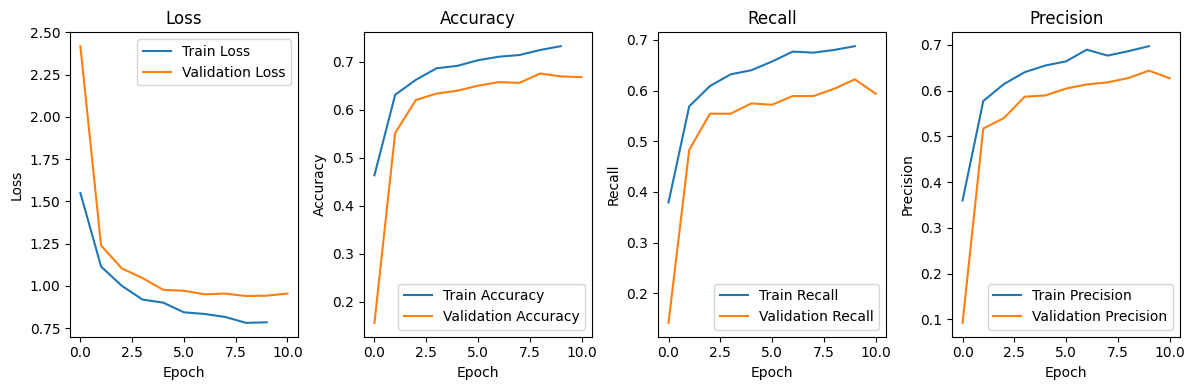

In [19]:
basic_model.plot_metrics()

Let's try the same model, but with lower learning rate and for more epochs:

In [20]:
%%time
basic_model_2 = MushroomModel(num_classes=dm.num_classes,
                            transfer=True,
                            learning_rate=2e-4)

trainer = pl.Trainer(max_epochs=15)
trainer.fit(basic_model_2, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | criterion         | CrossEntropyLoss    | 0     
2 | train_acc         | MulticlassAccuracy  | 0     
3 | val_acc           | MulticlassAccuracy  | 0     
4 | train_recall      | MulticlassRecall    | 0     
5 | val_recall        | MulticlassRecall    | 0     
6 | train_precision   | MulticlassPrecision | 0     
7 | val_precision     | MulticlassPrecision | 0     
---------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.2419111728668213
avg_val_acc: 0.140625
avg_val_recall: 0.13854166865348816
avg_val_precision: 0.19199562072753906
------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.705532193183899
avg_val_acc: 0.4008941948413849
avg_val_recall: 0.30137917399406433
avg_val_precision: 0.2535945177078247
------------------------------
avg_train_loss: 1.8964616060256958


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.475568413734436
avg_val_acc: 0.505216121673584
avg_val_recall: 0.4146232306957245
avg_val_precision: 0.4055418074131012
------------------------------
avg_train_loss: 1.576270580291748


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.3495211601257324
avg_val_acc: 0.5335320234298706
avg_val_recall: 0.4336937963962555
avg_val_precision: 0.4446427524089813
------------------------------
avg_train_loss: 1.39228355884552


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.269627332687378
avg_val_acc: 0.5484351515769958
avg_val_recall: 0.45559534430503845
avg_val_precision: 0.4777079224586487
------------------------------
avg_train_loss: 1.2735321521759033


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.205590844154358
avg_val_acc: 0.5946348905563354
avg_val_recall: 0.5192771553993225
avg_val_precision: 0.521167516708374
------------------------------
avg_train_loss: 1.1945993900299072


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.1568256616592407
avg_val_acc: 0.6095380187034607
avg_val_recall: 0.5302492380142212
avg_val_precision: 0.5789704918861389
------------------------------
avg_train_loss: 1.1352428197860718


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.117142915725708
avg_val_acc: 0.6140089631080627
avg_val_recall: 0.5426125526428223
avg_val_precision: 0.5686925649642944
------------------------------
avg_train_loss: 1.0874611139297485


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0990427732467651
avg_val_acc: 0.6244411468505859
avg_val_recall: 0.5664190649986267
avg_val_precision: 0.5883288979530334
------------------------------
avg_train_loss: 1.0571422576904297


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.064943552017212
avg_val_acc: 0.6408345699310303
avg_val_recall: 0.5721795558929443
avg_val_precision: 0.6001886129379272
------------------------------
avg_train_loss: 1.0218414068222046


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0551196336746216
avg_val_acc: 0.6274217367172241
avg_val_recall: 0.5504884719848633
avg_val_precision: 0.5842704772949219
------------------------------
avg_train_loss: 0.995319664478302


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.052163004875183
avg_val_acc: 0.6423248648643494
avg_val_recall: 0.5912029147148132
avg_val_precision: 0.6048617362976074
------------------------------
avg_train_loss: 0.9727226495742798


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0313777923583984
avg_val_acc: 0.6438152194023132
avg_val_recall: 0.5679673552513123
avg_val_precision: 0.6154189109802246
------------------------------
avg_train_loss: 0.9627177715301514


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0190458297729492
avg_val_acc: 0.6408345699310303
avg_val_recall: 0.5705834031105042
avg_val_precision: 0.591702938079834
------------------------------
avg_train_loss: 0.9449373483657837


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.010067105293274
avg_val_acc: 0.6378539204597473
avg_val_recall: 0.5653497576713562
avg_val_precision: 0.6007344126701355
------------------------------
avg_train_loss: 0.9209539890289307


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


avg_val_loss: 1.0065762996673584
avg_val_acc: 0.6482861638069153
avg_val_recall: 0.5782458186149597
avg_val_precision: 0.613315761089325
------------------------------
avg_train_loss: 0.9042667746543884
CPU times: user 2min 1s, sys: 29 s, total: 2min 30s
Wall time: 15min 50s


In [21]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/basic_model_2_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [22]:
print_metrics(basic_model_2)

Final Training Loss: 0.9043
Final Validation Loss: 1.0066
--------------------
Final Training Accuracy: 0.6171
Final Validation Accuracy: 0.5913
--------------------
Final Training Recall: 0.5340
Final Validation Recall: 0.5146
--------------------
Final Training Precision: 0.6510
Final Validation Precision: 0.5994
--------------------


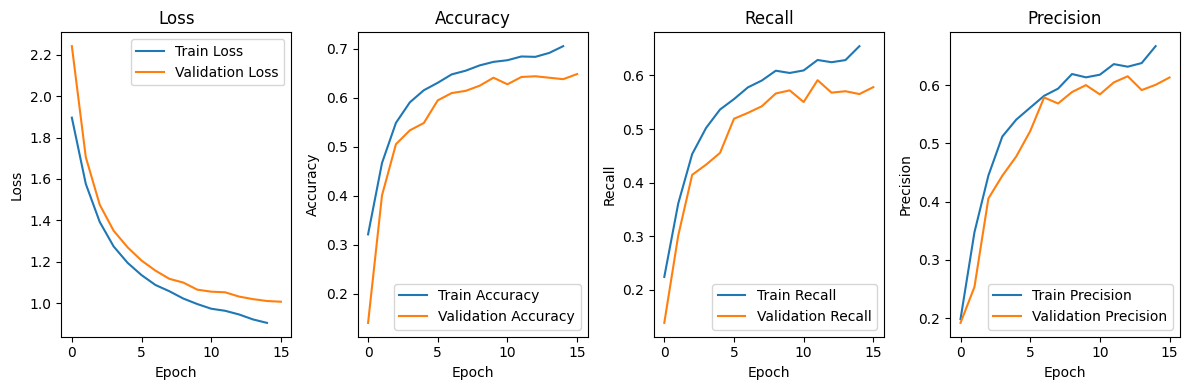

In [23]:
basic_model_2.plot_metrics()

## Pre-trained CNN with Fine-tuning and Image Augmentation

In [24]:
%%time
unfreeze_layers=['layer3', 'layer4']
tuned_model = MushroomModel(num_classes=dm.num_classes,
                            transfer=True,
                            unfreeze_layers=unfreeze_layers)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(tuned_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | criterion         | CrossEntropyLoss    | 0     
2 | train_acc         | MulticlassAccuracy  | 0     
3 | val_acc           | MulticlassAccuracy  | 0     
4 | train_recall      | MulticlassRecall    | 0     
5 | val_recall        | MulticlassRecall    | 0     
6 | train_precision   | MulticlassPrecision | 0     
7 | val_precision     | MulticlassPrecision | 0     
---------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.489630699157715
avg_val_acc: 0.09375
avg_val_recall: 0.17060185968875885
avg_val_precision: 0.1026785746216774
------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.2724404335021973
avg_val_acc: 0.6169895529747009
avg_val_recall: 0.5546927452087402
avg_val_precision: 0.5808700919151306
------------------------------
avg_train_loss: 1.0466299057006836


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.9311386942863464
avg_val_acc: 0.6989567875862122
avg_val_recall: 0.6044455170631409
avg_val_precision: 0.6319051384925842
------------------------------
avg_train_loss: 0.5522778034210205


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0694249868392944
avg_val_acc: 0.7093889713287354
avg_val_recall: 0.6312161684036255
avg_val_precision: 0.6425034999847412
------------------------------
avg_train_loss: 0.34900909662246704


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8493230938911438
avg_val_acc: 0.7228018045425415
avg_val_recall: 0.6473567485809326
avg_val_precision: 0.6759417057037354
------------------------------
avg_train_loss: 0.22733792662620544


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8672858476638794
avg_val_acc: 0.7719821333885193
avg_val_recall: 0.6811220645904541
avg_val_precision: 0.6815001964569092
------------------------------
avg_train_loss: 0.14581014215946198


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.0888408422470093
avg_val_acc: 0.7317436933517456
avg_val_recall: 0.683500349521637
avg_val_precision: 0.7173064351081848
------------------------------
avg_train_loss: 0.13125818967819214


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8709865808486938
avg_val_acc: 0.7704917788505554
avg_val_recall: 0.7134559154510498
avg_val_precision: 0.7171533703804016
------------------------------
avg_train_loss: 0.11531509459018707


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8262600898742676
avg_val_acc: 0.7853949069976807
avg_val_recall: 0.7429953217506409
avg_val_precision: 0.7587887048721313
------------------------------
avg_train_loss: 0.09639083594083786


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 1.126301884651184
avg_val_acc: 0.752608060836792
avg_val_recall: 0.6705222129821777
avg_val_precision: 0.7008058428764343
------------------------------
avg_train_loss: 0.09405538439750671


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8206373453140259
avg_val_acc: 0.7779433727264404
avg_val_recall: 0.7188803553581238
avg_val_precision: 0.7106982469558716
------------------------------
avg_train_loss: 0.06464385986328125


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 25s, sys: 21.5 s, total: 1min 47s
Wall time: 10min 59s


In [25]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/tuned_model_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [26]:
print_metrics(tuned_model)

Final Training Loss: 0.0646
Final Validation Loss: 0.8206
--------------------
Final Training Accuracy: 0.9056
Final Validation Accuracy: 0.7278
--------------------
Final Training Recall: 0.8887
Final Validation Recall: 0.6797
--------------------
Final Training Precision: 0.8993
Final Validation Precision: 0.7016
--------------------


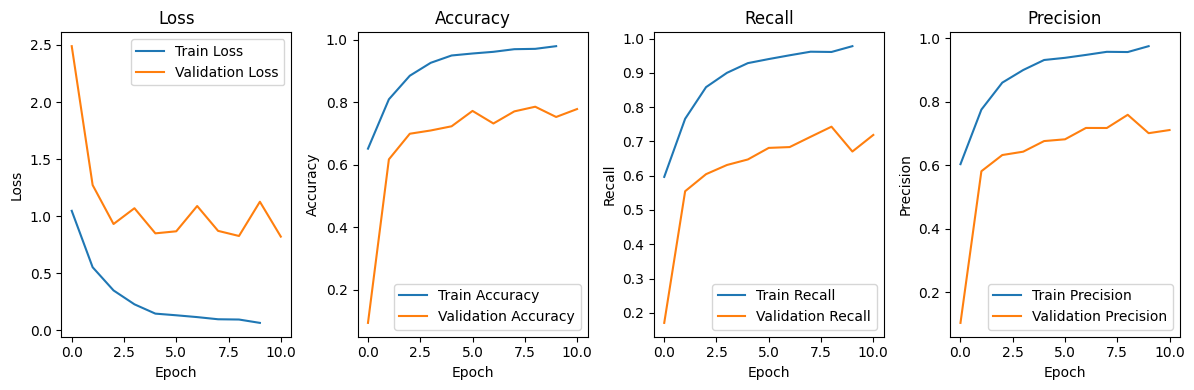

In [27]:
tuned_model.plot_metrics()

The metrics are better for this model, but it's clearly overfitting. Let's try unfreezing only one last layer and lowering the learning rate.

In [28]:
%%time
unfreeze_layers=['layer4']
tuned_model_2 = MushroomModel(num_classes=dm.num_classes,
                            transfer=True,
                            unfreeze_layers=unfreeze_layers,
                            learning_rate=2e-4)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(tuned_model_2, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | criterion         | CrossEntropyLoss    | 0     
2 | train_acc         | MulticlassAccuracy  | 0     
3 | val_acc           | MulticlassAccuracy  | 0     
4 | train_recall      | MulticlassRecall    | 0     
5 | val_recall        | MulticlassRecall    | 0     
6 | train_precision   | MulticlassPrecision | 0     
7 | val_precision     | MulticlassPrecision | 0     
---------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.1938390731811523
avg_val_acc: 0.171875
avg_val_recall: 0.06954365223646164
avg_val_precision: 0.04485171288251877
------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.5427103042602539
avg_val_acc: 0.8241430521011353
avg_val_recall: 0.781988799571991
avg_val_precision: 0.7960706353187561
------------------------------
avg_train_loss: 0.2680385708808899


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.549161970615387
avg_val_acc: 0.8360655903816223
avg_val_recall: 0.7877747416496277
avg_val_precision: 0.8133044838905334
------------------------------
avg_train_loss: 0.02175014279782772


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.548550546169281
avg_val_acc: 0.8330849409103394
avg_val_recall: 0.7823275327682495
avg_val_precision: 0.8038467168807983
------------------------------
avg_train_loss: 0.010287311859428883


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.5722706913948059
avg_val_acc: 0.8345752358436584
avg_val_recall: 0.7917329668998718
avg_val_precision: 0.8135160207748413
------------------------------
avg_train_loss: 0.0062955645844340324


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.5815563797950745
avg_val_acc: 0.8375558853149414
avg_val_recall: 0.7968198657035828
avg_val_precision: 0.8115317821502686
------------------------------
avg_train_loss: 0.0032723729964345694


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6290056109428406
avg_val_acc: 0.8360655903816223
avg_val_recall: 0.7893688678741455
avg_val_precision: 0.8202288150787354
------------------------------
avg_train_loss: 0.002246841322630644


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6124707460403442
avg_val_acc: 0.8420268297195435
avg_val_recall: 0.7999592423439026
avg_val_precision: 0.8158849477767944
------------------------------
avg_train_loss: 0.001710284035652876


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6168134212493896
avg_val_acc: 0.8390461802482605
avg_val_recall: 0.7992727160453796
avg_val_precision: 0.8239328861236572
------------------------------
avg_train_loss: 0.0014722386840730906


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6402592062950134
avg_val_acc: 0.8375558853149414
avg_val_recall: 0.8021667003631592
avg_val_precision: 0.8254740238189697
------------------------------
avg_train_loss: 0.0015321202808991075


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6646848320960999
avg_val_acc: 0.8420268297195435
avg_val_recall: 0.7948037981987
avg_val_precision: 0.8095075488090515
------------------------------
avg_train_loss: 0.001330659375526011


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 23s, sys: 21.3 s, total: 1min 44s
Wall time: 11min 12s


In [29]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/tuned_model_2_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [30]:
print_metrics(tuned_model_2)

Final Training Loss: 0.0013
Final Validation Loss: 0.6647
--------------------
Final Training Accuracy: 0.9944
Final Validation Accuracy: 0.8299
--------------------
Final Training Recall: 0.9920
Final Validation Recall: 0.8002
--------------------
Final Training Precision: 0.9956
Final Validation Precision: 0.8248
--------------------


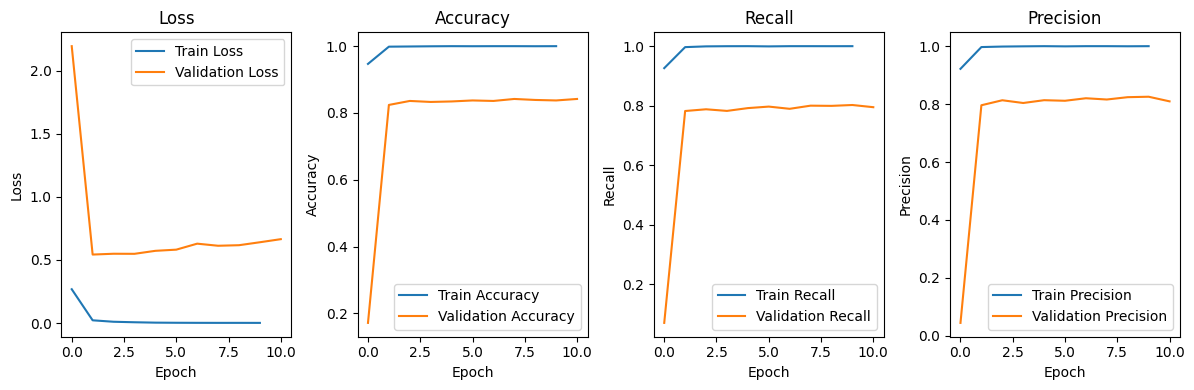

In [31]:
tuned_model_2.plot_metrics()

The metrics got better, but the model is still overfitting. Let's try adding dropout.

In [32]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [50]:
class TunedMushroomModel(pl.LightningModule):
    def __init__(self, num_classes,
              learning_rate=1e-3,
              transfer=False,
              unfreeze_layers=None,
              dropout_rate=0.5,
              early_stop_epochs=10,
              weight_decay=1e-4,
              additional_fc=False,
              feature_extractor=models.resnet18(weights=ResNet18_Weights.DEFAULT),
              criterion=torch.nn.CrossEntropyLoss()):
        super().__init__()

        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.early_stop_epochs = early_stop_epochs
        self.weight_decay = weight_decay

        self.feature_extractor = feature_extractor
        in_features = self.feature_extractor.fc.in_features

        if transfer:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

            if unfreeze_layers is not None:
                  for name, child in self.feature_extractor.named_children():
                      if name in unfreeze_layers:
                          for params in child.parameters():
                              params.requires_grad = True

        self.dropout = torch.nn.Dropout(p=self.dropout_rate)

        if additional_fc:
          self.feature_extractor.fc = torch.nn.Sequential(
              nn.Linear(in_features, in_features//2),
              nn.ReLU(),
              self.dropout,
              nn.Linear(in_features//2, num_classes))
        else:
          self.feature_extractor.fc = torch.nn.Sequential(
              self.dropout,
              torch.nn.Linear(in_features, self.num_classes)
          )

        self.criterion = criterion

        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_recall = Recall(average='macro', num_classes=num_classes,
                                   task='multiclass')
        self.val_recall = Recall(average='macro', num_classes=num_classes,
                                 task='multiclass')

        self.train_precision = Precision(average='macro', num_classes=num_classes,
                                         task='multiclass')
        self.val_precision = Precision(average='macro', num_classes=num_classes,
                                       task='multiclass')

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_recalls = []
        self.val_recalls = []
        self.train_precisions = []
        self.val_precisions = []

        self.early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=self.early_stop_epochs,
            verbose=True,
            mode='min'
        )


    def forward(self, x):
        return self.feature_extractor(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        train_acc = self.train_acc(y_hat, y)
        train_recall = self.train_recall(y_hat, y)
        train_precision = self.train_precision(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_accuracy', train_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_recall', train_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_precision', train_precision, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def validation_step(self, batch, batch_idx):
      with torch.no_grad():
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        val_acc = self.val_acc(logits, y)
        val_recall = self.val_recall(logits, y)
        val_precision = self.val_precision(logits, y)

        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_accuracy', val_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_recall', val_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_precision', val_precision, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def on_train_epoch_end(self):
        avg_train_loss = self.trainer.callback_metrics['train_loss'].mean()
        print(f"avg_train_loss: {avg_train_loss}")
        self.train_losses.append(avg_train_loss.item())

        avg_train_acc = self.trainer.callback_metrics['train_accuracy'].mean()
        train_acc = self.train_acc.compute()
        self.train_accuracies.append(avg_train_acc.item())

        avg_train_recall = self.trainer.callback_metrics['train_recall'].mean()
        train_recall = self.train_recall.compute()
        self.train_recalls.append(avg_train_recall.item())

        avg_train_precision = self.trainer.callback_metrics['train_precision'].mean()
        self.train_precisions.append(avg_train_precision.item())


    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val_loss'].mean()
        print(f"avg_val_loss: {avg_val_loss}")
        self.val_losses.append(avg_val_loss.item())

        avg_val_acc = self.trainer.callback_metrics['val_accuracy'].mean()
        print("avg_val_acc:", avg_val_acc.item())
        self.val_accuracies.append(avg_val_acc.item())

        avg_val_recall = self.trainer.callback_metrics['val_recall'].mean()
        print("avg_val_recall:", avg_val_recall.item())
        self.val_recalls.append(avg_val_recall.item())

        avg_val_precision = self.trainer.callback_metrics['val_precision'].mean()
        print("avg_val_precision:", avg_val_precision.item())
        self.val_precisions.append(avg_val_precision.item())


    def configure_callbacks(self):
       return [self.early_stop_callback]


    def plot_metrics(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 4, 2)
        plt.plot(self.train_accuracies, label="Train Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1, 4, 3)
        plt.plot(self.train_recalls, label="Train Recall")
        plt.plot(self.val_recalls, label="Validation Recall")
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.title('Recall')
        plt.legend()

        plt.subplot(1, 4, 4)
        plt.plot(self.train_precisions, label="Train Precision")
        plt.plot(self.val_precisions, label="Validation Precision")
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.title('Precision')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate,
                                weight_decay=self.weight_decay)

In [34]:
%%time
unfreeze_layers=['layer4']
tuned_model_dropout = TunedMushroomModel(num_classes=dm.num_classes,
                                  transfer=True,
                                  unfreeze_layers=unfreeze_layers,
                                  learning_rate=2e-4)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(tuned_model_dropout, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | dropout           | Dropout             | 0     
2 | criterion         | CrossEntropyLoss    | 0     
3 | train_acc         | MulticlassAccuracy  | 0     
4 | val_acc           | MulticlassAccuracy  | 0     
5 | train_recall      | MulticlassRecall    | 0     
6 | val_recall        | MulticlassRecall    | 0     
7 | train_precision   | MulticlassPrecision | 0     
8 | val_p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.2478599548339844
avg_val_acc: 0.109375
avg_val_recall: 0.1443452388048172
avg_val_precision: 0.06881062686443329


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.653


avg_val_loss: 0.652937114238739
avg_val_acc: 0.7794336676597595
avg_val_recall: 0.7122752070426941
avg_val_precision: 0.7271448373794556
avg_train_loss: 1.0602977275848389


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.587


avg_val_loss: 0.5868025422096252
avg_val_acc: 0.7839046120643616
avg_val_recall: 0.7173194289207458
avg_val_precision: 0.7285137176513672
avg_train_loss: 0.33033573627471924


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.5890093445777893
avg_val_acc: 0.8017883896827698
avg_val_recall: 0.7578593492507935
avg_val_precision: 0.7710412740707397
avg_train_loss: 0.10305715352296829


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.568


avg_val_loss: 0.5682272911071777
avg_val_acc: 0.8211624622344971
avg_val_recall: 0.7763870358467102
avg_val_precision: 0.7925539016723633
avg_train_loss: 0.039934076368808746


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.564


avg_val_loss: 0.5640254616737366
avg_val_acc: 0.8241430521011353
avg_val_recall: 0.7721453309059143
avg_val_precision: 0.795174777507782
avg_train_loss: 0.018724188208580017


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6047120094299316
avg_val_acc: 0.812220573425293
avg_val_recall: 0.7611505389213562
avg_val_precision: 0.7721726894378662
avg_train_loss: 0.013453357852995396


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6931952238082886
avg_val_acc: 0.7973174452781677
avg_val_recall: 0.7393743991851807
avg_val_precision: 0.7670080065727234
avg_train_loss: 0.014632614329457283


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7526399493217468
avg_val_acc: 0.7853949069976807
avg_val_recall: 0.7244385480880737
avg_val_precision: 0.7411401867866516
avg_train_loss: 0.021631995216012


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7970055341720581
avg_val_acc: 0.7809240221977234
avg_val_recall: 0.730226993560791
avg_val_precision: 0.7583602070808411
avg_train_loss: 0.04354770481586456


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7292088270187378
avg_val_acc: 0.7913562059402466
avg_val_recall: 0.7449086308479309
avg_val_precision: 0.755106508731842
avg_train_loss: 0.04146652668714523


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 24s, sys: 21.3 s, total: 1min 45s
Wall time: 10min 40s


In [35]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/tuned_model_dropout_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [36]:
print_metrics(tuned_model_dropout)

Final Training Loss: 0.0415
Final Validation Loss: 0.7292
--------------------
Final Training Accuracy: 0.9465
Final Validation Accuracy: 0.7913
--------------------
Final Training Recall: 0.9366
Final Validation Recall: 0.7647
--------------------
Final Training Precision: 0.9477
Final Validation Precision: 0.7810
--------------------


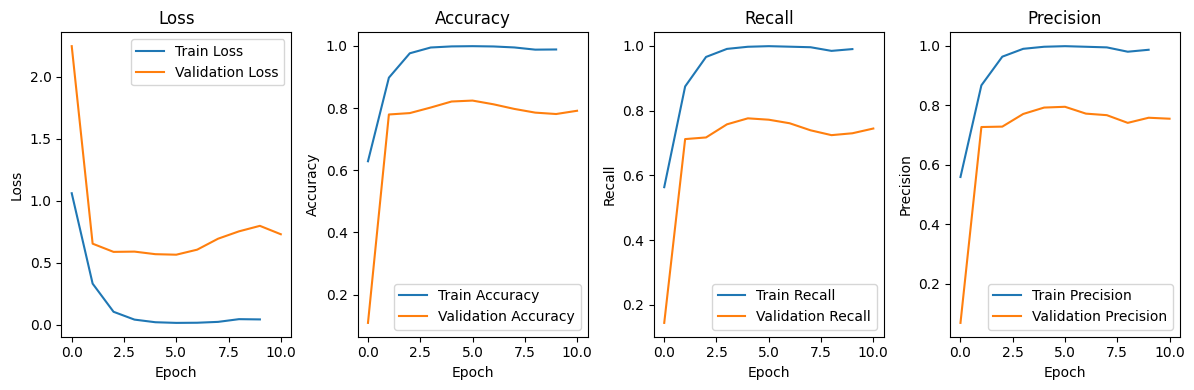

In [37]:
tuned_model_dropout.plot_metrics()

Now, the model performs slightly worse than the last one, but also overfits less. Let's try changing the weight decay to increase regularization penalty:

In [43]:
%%time
unfreeze_layers=['layer4']
tuned_model_dropout_decay = TunedMushroomModel(num_classes=dm.num_classes,
                                  transfer=True,
                                  unfreeze_layers=unfreeze_layers,
                                  learning_rate=2e-4,
                                  weight_decay=5e-4,
                                  early_stop_epochs=5)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(tuned_model_dropout_decay, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.2 M
1 | dropout           | Dropout             | 0     
2 | criterion         | CrossEntropyLoss    | 0     
3 | train_acc         | MulticlassAccuracy  | 0     
4 | val_acc           | MulticlassAccuracy  | 0     
5 | train_recall      | MulticlassRecall    | 0     
6 | val_recall        | MulticlassRecall    | 0     
7 | train_precision   | MulticlassPrecision | 0     
8 | val_p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.5231072902679443
avg_val_acc: 0.046875
avg_val_recall: 0.125
avg_val_precision: 0.04444444552063942


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.659


avg_val_loss: 0.6588401794433594
avg_val_acc: 0.7704917788505554
avg_val_recall: 0.7147625088691711
avg_val_precision: 0.7352675795555115
avg_train_loss: 1.0350751876831055


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.592


avg_val_loss: 0.5923866033554077
avg_val_acc: 0.7898658514022827
avg_val_recall: 0.7414641380310059
avg_val_precision: 0.7612577676773071
avg_train_loss: 0.34095069766044617


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.5982400178909302
avg_val_acc: 0.8152011632919312
avg_val_recall: 0.7614262104034424
avg_val_precision: 0.7703117728233337
avg_train_loss: 0.10141590237617493


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7520894408226013
avg_val_acc: 0.7868852615356445
avg_val_recall: 0.7396592497825623
avg_val_precision: 0.7819115519523621
avg_train_loss: 0.040138646960258484


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.580


avg_val_loss: 0.580476701259613
avg_val_acc: 0.8107302784919739
avg_val_recall: 0.7572095394134521
avg_val_precision: 0.7795709371566772
avg_train_loss: 0.028408203274011612


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.586950957775116
avg_val_acc: 0.8137108683586121
avg_val_recall: 0.7690045833587646
avg_val_precision: 0.7833255529403687
avg_train_loss: 0.011717027053236961


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6776010990142822
avg_val_acc: 0.8002980351448059
avg_val_recall: 0.7280288934707642
avg_val_precision: 0.7536718845367432
avg_train_loss: 0.019626637920737267


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.766887903213501
avg_val_acc: 0.7943367958068848
avg_val_recall: 0.7316408157348633
avg_val_precision: 0.767350435256958
avg_train_loss: 0.025128073990345


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.806500256061554
avg_val_acc: 0.7749627232551575
avg_val_recall: 0.713020384311676
avg_val_precision: 0.7240409851074219
avg_train_loss: 0.05606124550104141


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.580. Signaling Trainer to stop.


avg_val_loss: 0.7024918794631958
avg_val_acc: 0.7913562059402466
avg_val_recall: 0.7261102795600891
avg_val_precision: 0.7455733418464661
avg_train_loss: 0.08263405412435532


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 24s, sys: 21.1 s, total: 1min 45s
Wall time: 10min 40s


In [44]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/tuned_model_dropout_decay_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [45]:
print_metrics(tuned_model_dropout_decay)

Final Training Loss: 0.0826
Final Validation Loss: 0.7025
--------------------
Final Training Accuracy: 0.9450
Final Validation Accuracy: 0.7877
--------------------
Final Training Recall: 0.9354
Final Validation Recall: 0.7655
--------------------
Final Training Precision: 0.9443
Final Validation Precision: 0.7735
--------------------


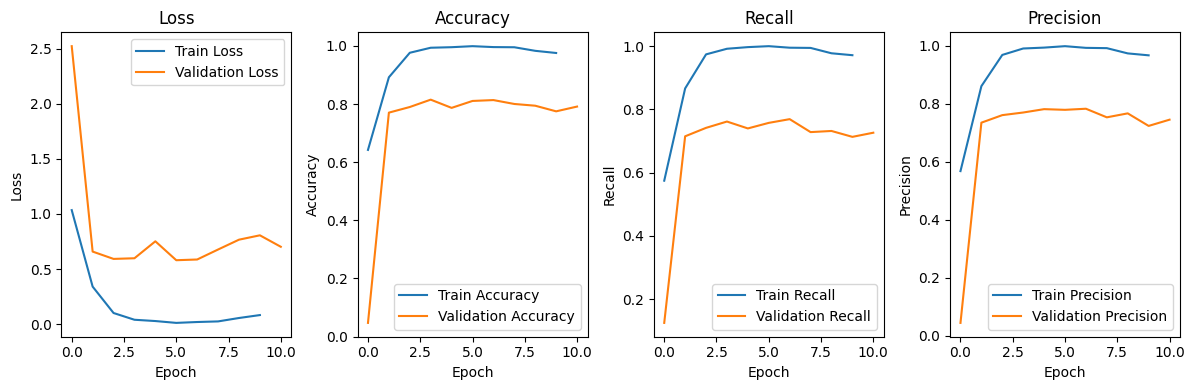

In [46]:
tuned_model_dropout_decay.plot_metrics()

This model is overfitting less, but it also performs worse on both training and validation data.

Let's try adding an additional fully connected layer to the end:

In [51]:
%%time
unfreeze_layers=['layer4']
tuned_model_add_fc = TunedMushroomModel(num_classes=dm.num_classes,
                                  transfer=True,
                                  unfreeze_layers=unfreeze_layers,
                                  learning_rate=2e-4,
                                  additional_fc=True,
                                  early_stop_epochs=5)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(tuned_model_add_fc, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | feature_extractor | ResNet              | 11.3 M
1 | dropout           | Dropout             | 0     
2 | criterion         | CrossEntropyLoss    | 0     
3 | train_acc         | MulticlassAccuracy  | 0     
4 | val_acc           | MulticlassAccuracy  | 0     
5 | train_recall      | MulticlassRecall    | 0     
6 | val_recall        | MulticlassRecall    | 0     
7 | train_precision   | MulticlassPrecision | 0     
8 | val_p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 2.3029916286468506
avg_val_acc: 0.109375
avg_val_recall: 0.10740740597248077
avg_val_precision: 0.07749637216329575


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.723


avg_val_loss: 0.7228174805641174
avg_val_acc: 0.7391952276229858
avg_val_recall: 0.6873170733451843
avg_val_precision: 0.7090708613395691
avg_train_loss: 1.1227551698684692


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.072 >= min_delta = 0.001. New best score: 0.651


avg_val_loss: 0.6506839990615845
avg_val_acc: 0.7540983557701111
avg_val_recall: 0.682415246963501
avg_val_precision: 0.6715838313102722
avg_train_loss: 0.417805939912796


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7381642460823059
avg_val_acc: 0.7809240221977234
avg_val_recall: 0.7130853533744812
avg_val_precision: 0.7547968626022339
avg_train_loss: 0.14148512482643127


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6858959794044495
avg_val_acc: 0.7868852615356445
avg_val_recall: 0.7326920032501221
avg_val_precision: 0.7232970595359802
avg_train_loss: 0.07209335267543793


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.648


avg_val_loss: 0.6477558612823486
avg_val_acc: 0.8211624622344971
avg_val_recall: 0.7940133810043335
avg_val_precision: 0.7988439798355103
avg_train_loss: 0.07292935997247696


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7483972311019897
avg_val_acc: 0.8032786846160889
avg_val_recall: 0.7506623268127441
avg_val_precision: 0.7703595161437988
avg_train_loss: 0.04124441370368004


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.8614291548728943
avg_val_acc: 0.7645305395126343
avg_val_recall: 0.687049388885498
avg_val_precision: 0.7090418338775635
avg_train_loss: 0.0494958758354187


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.7022466063499451
avg_val_acc: 0.8181818127632141
avg_val_recall: 0.7656412124633789
avg_val_precision: 0.7715337872505188
avg_train_loss: 0.04247265309095383


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_loss: 0.6972509622573853
avg_val_acc: 0.7973174452781677
avg_val_recall: 0.7577313184738159
avg_val_precision: 0.776665449142456
avg_train_loss: 0.03482804074883461


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.648. Signaling Trainer to stop.


avg_val_loss: 0.6911704540252686
avg_val_acc: 0.8181818127632141
avg_val_recall: 0.7513229250907898
avg_val_precision: 0.7835382223129272
avg_train_loss: 0.051313307136297226


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 24s, sys: 21.8 s, total: 1min 46s
Wall time: 10min 53s


In [52]:
checkpoint_path = "/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S1_Mushrooms/tuned_model_add_fc_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

In [53]:
print_metrics(tuned_model_add_fc)

Final Training Loss: 0.0513
Final Validation Loss: 0.6912
--------------------
Final Training Accuracy: 0.9338
Final Validation Accuracy: 0.7820
--------------------
Final Training Recall: 0.9183
Final Validation Recall: 0.7605
--------------------
Final Training Precision: 0.9373
Final Validation Precision: 0.7678
--------------------


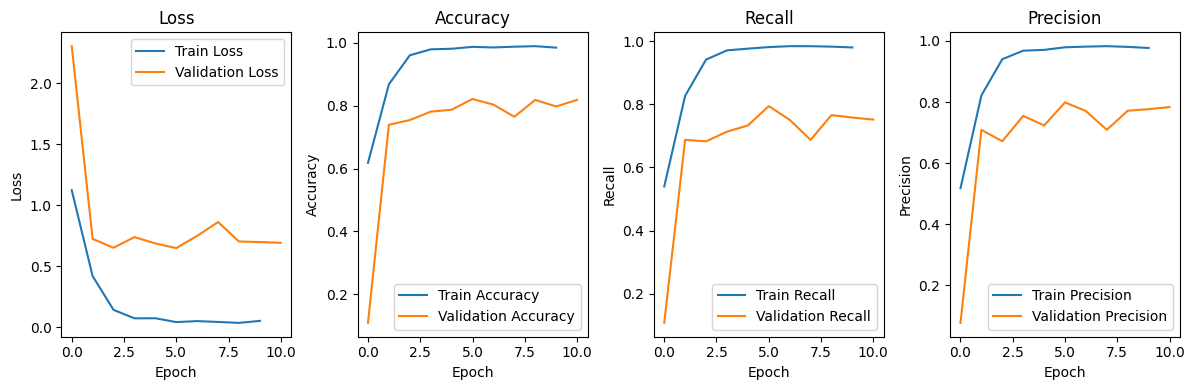

In [54]:
tuned_model_add_fc.plot_metrics()

The model is overfitting less, though the performance got worse, compared to the model with simple dropout.

## Testing the model with test_dataloader

In [55]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from torchmetrics import ConfusionMatrix
from timeit import default_timer as timer

In [56]:
def evaluate_model(model, test_loader):
    model.eval()
    model.freeze()

    cm = ConfusionMatrix(num_classes=10, task='multiclass')
    all_preds = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        total_time = 0
        total_images = 0

        for x, y in test_loader:
            start_time = timer()

            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            loss = F.cross_entropy(logits, y)

            cm(preds, y)

            all_preds.extend(preds.tolist())
            all_labels.extend(y.tolist())
            all_losses.append(loss.item())

            inference_time = timer() - start_time
            total_time += inference_time
            total_images += x.size(0)

        print(f'Total inference time: {total_time:.3f}s')
        print(f'Average inference time per image: {total_time / total_images:.6f}s')

        total_loss = sum(all_losses) / len(all_losses)
        total_accuracy = accuracy_score(all_labels, all_preds)
        total_precision = precision_score(all_labels, all_preds, average='macro')
        total_recall = recall_score(all_labels, all_preds, average='macro')

        print(f'Total Loss: {total_loss:.4f}')
        print(f'Total Accuracy: {total_accuracy:.4f}')
        print(f'Total Precision: {total_precision:.4f}')
        print(f'Total Recall: {total_recall:.4f}')

        print(classification_report(all_labels, all_preds, zero_division=1))

        fig, ax = plt.subplots()
        cm.plot(ax=ax)
        plt.show()

Total inference time: 60.083s
Average inference time per image: 0.089409s
Total Loss: 0.6770
Total Accuracy: 0.8333
Total Precision: 0.8260
Total Recall: 0.7885
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        34
           1       0.83      0.82      0.83        85
           2       0.91      0.94      0.93       108
           3       0.80      0.76      0.78        78
           4       0.92      0.80      0.86        41
           5       0.83      0.86      0.85        29
           6       0.81      0.90      0.85       147
           7       0.82      0.83      0.82       124
           8       0.72      0.50      0.59        26

    accuracy                           0.83       672
   macro avg       0.83      0.79      0.80       672
weighted avg       0.83      0.83      0.83       672



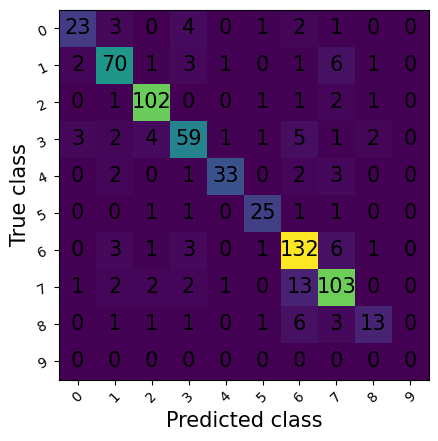

In [57]:
evaluate_model(tuned_model, test_dataloader)

Total inference time: 61.163s
Average inference time per image: 0.091017s
Total Loss: 0.6770
Total Accuracy: 0.8333
Total Precision: 0.8260
Total Recall: 0.7885
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        34
           1       0.83      0.82      0.83        85
           2       0.91      0.94      0.93       108
           3       0.80      0.76      0.78        78
           4       0.92      0.80      0.86        41
           5       0.83      0.86      0.85        29
           6       0.81      0.90      0.85       147
           7       0.82      0.83      0.82       124
           8       0.72      0.50      0.59        26

    accuracy                           0.83       672
   macro avg       0.83      0.79      0.80       672
weighted avg       0.83      0.83      0.83       672



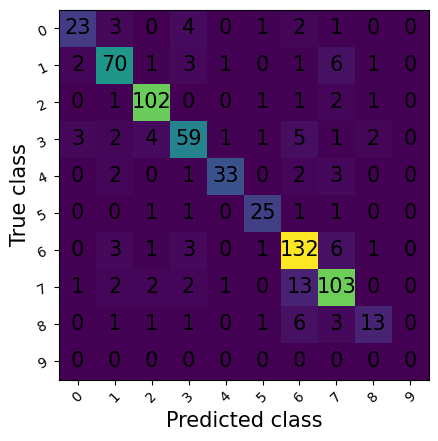

In [58]:
evaluate_model(tuned_model_2, test_dataloader)

Total inference time: 61.156s
Average inference time per image: 0.091006s
Total Loss: 0.7038
Total Accuracy: 0.8199
Total Precision: 0.8163
Total Recall: 0.7802
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        34
           1       0.95      0.68      0.79        85
           2       0.93      0.93      0.93       108
           3       0.67      0.77      0.72        78
           4       0.81      0.71      0.75        41
           5       1.00      0.83      0.91        29
           6       0.77      0.93      0.84       147
           7       0.87      0.82      0.85       124
           8       0.61      0.54      0.57        26

    accuracy                           0.82       672
   macro avg       0.82      0.78      0.79       672
weighted avg       0.83      0.82      0.82       672



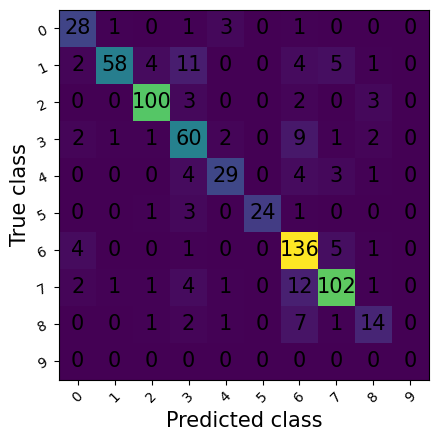

In [59]:
evaluate_model(tuned_model_dropout, test_dataloader)

Total inference time: 60.170s
Average inference time per image: 0.089538s
Total Loss: 0.7877
Total Accuracy: 0.7768
Total Precision: 0.7781
Total Recall: 0.7503
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        34
           1       0.78      0.76      0.77        85
           2       0.80      0.91      0.85       108
           3       0.85      0.53      0.65        78
           4       0.90      0.68      0.78        41
           5       0.85      0.79      0.82        29
           6       0.73      0.88      0.80       147
           7       0.82      0.76      0.79       124
           8       0.53      0.73      0.61        26

    accuracy                           0.78       672
   macro avg       0.78      0.75      0.75       672
weighted avg       0.79      0.78      0.77       672



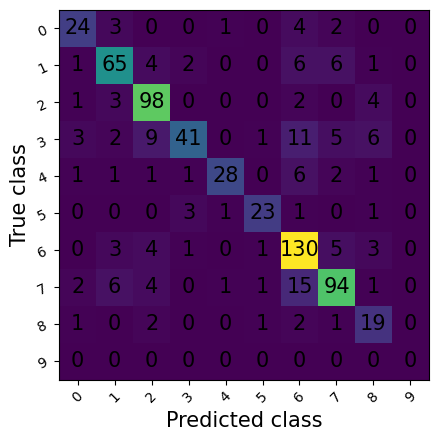

In [60]:
evaluate_model(tuned_model_dropout_decay, test_dataloader)

Total inference time: 61.005s
Average inference time per image: 0.090781s
Total Loss: 0.7599
Total Accuracy: 0.8199
Total Precision: 0.7981
Total Recall: 0.7838
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        34
           1       0.84      0.76      0.80        85
           2       0.93      0.91      0.92       108
           3       0.76      0.71      0.73        78
           4       0.85      0.68      0.76        41
           5       0.90      0.90      0.90        29
           6       0.79      0.93      0.85       147
           7       0.86      0.81      0.84       124
           8       0.55      0.62      0.58        26

    accuracy                           0.82       672
   macro avg       0.80      0.78      0.79       672
weighted avg       0.82      0.82      0.82       672



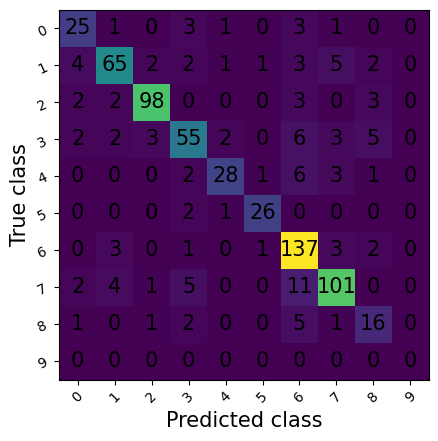

In [61]:
evaluate_model(tuned_model_add_fc, test_dataloader)

``tuned_model`` performance:
- Average inference time per image: 0.089409s
- Total Loss: 0.6770
- Total Accuracy: 0.8333
- Total Precision: 0.8260
- Total Recall: 0.7885

``tuned_model_2`` performance:
- Average inference time per image: 0.091017s
- Total Loss: 0.6770
- Total Accuracy: 0.8333
- Total Precision: 0.8260
- Total Recall: 0.7885

``tuned_model_dropout`` performance:
- Average inference time per image: 0.091006s
- Total Loss: 0.7038
- Total Accuracy: 0.8199
- Total Precision: 0.8163
- Total Recall: 0.7802

``tuned_model_dropout_decay`` performance:
- Average inference time per image: 0.089538s
- Total Loss: 0.7877
- Total Accuracy: 0.7768
- Total Precision: 0.7781
- Total Recall: 0.7503

``tuned_model_add_fc`` performance:
- Average inference time per image: 0.090781s
- Total Loss: 0.7599
- Total Accuracy: 0.8199
- Total Precision: 0.7981
- Total Recall: 0.7838

**Conclusions:** tuned_model (with unfreezing the last 2 layers in resnet18) works a bit better and faster than the other ones, though this model was clearly overfitting on the training data.

# Conclusions and Further improvement

- We have utilized data augmentation, transfer learning with pretrained model ResNet18, and regularization to get a moderately good result. The best-performing models are able to classify images into mushroom classes fairly well, though they are prone to overfitting and require further improvement.
- In further work, we would focus on improving the model performance. Also, it may be useful to get more granular class labels, since some mushroom classes contain both edible and poisonous subclasses.

**Disclaimer:**
The models still need improvement and are unable to correctly classify all of the mushroom images. Please, use with caution and relly on additional resources when using in real-world scenarios.